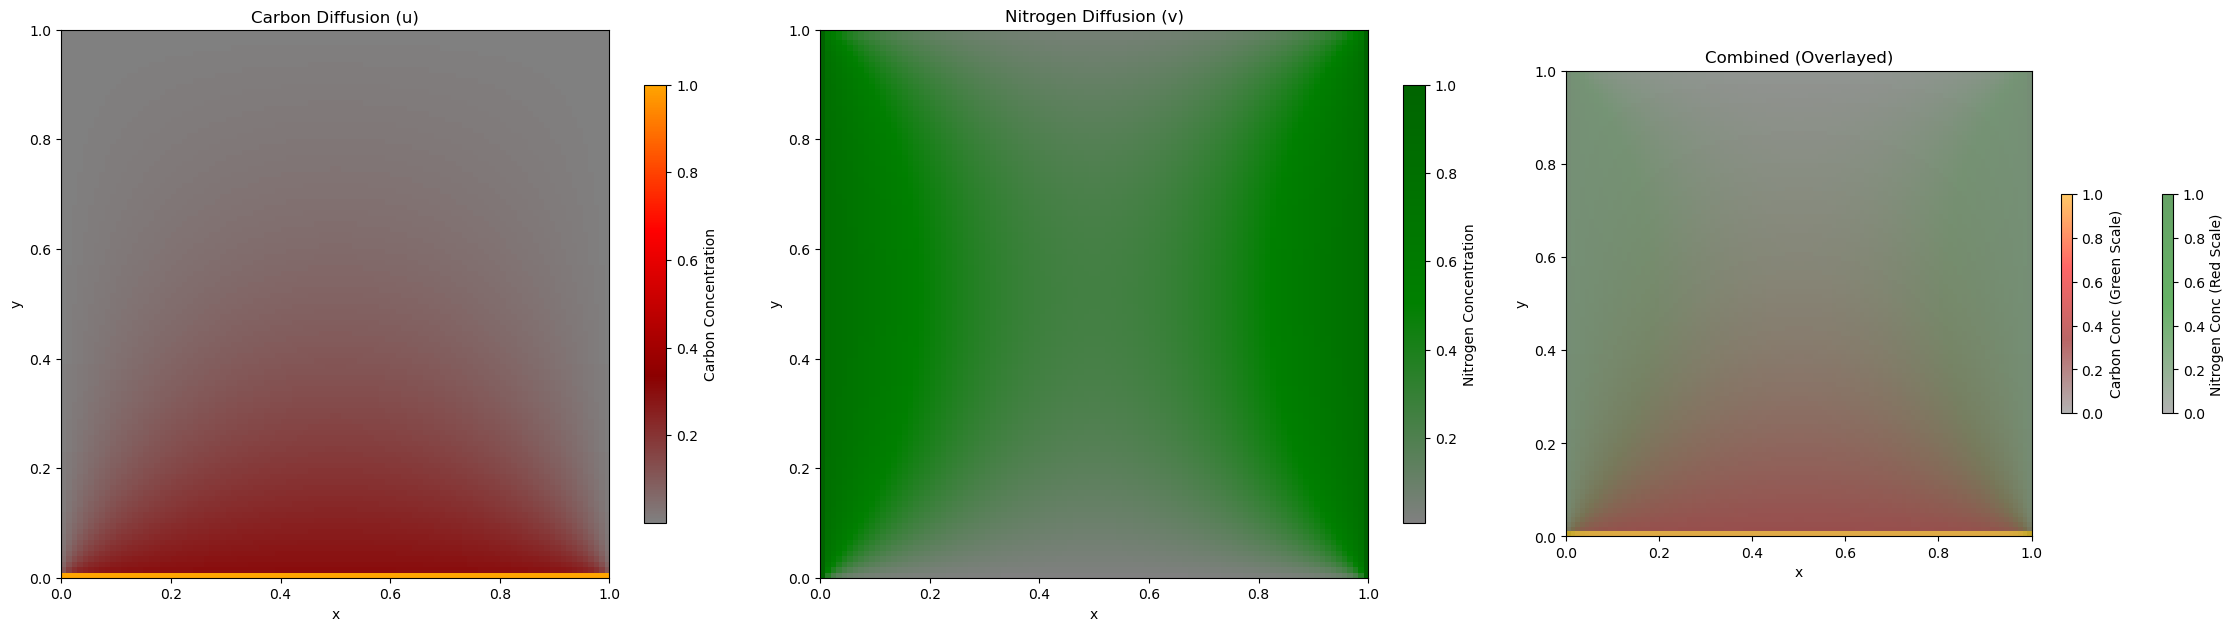

In [6]:
import numpy as np
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve, factorized
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Parameters
nx, ny = 100, 100
dx = dy = 1.0 / (nx - 1)
dt = 0.01
nt = 3000
Dc_u = 0.045
Dc_v = 0.0045
alpha_x_u = Dc_u * dt / (2 * dx**2)
alpha_y_u = Dc_u * dt / (2 * dy**2)
alpha_x_v = Dc_v * dt / (2 * dx**2)
alpha_y_v = Dc_v * dt / (2 * dy**2)
c_surface = 1.0    # Nitrogen surface concentration
c_surfacex = 1.0   # Carbon surface concentration
extent = [0, 1, 0, 1]

# Initial conditions
u = np.zeros((nx, ny))  # Carbon
v = np.zeros((nx, ny))  # Nitrogen

# Construct 2D matrices (Backward Euler formulation)
n = nx * ny
x_off_diag = np.ones(n-1)
x_off_diag[nx-1::nx] = 0
y_off_diag = np.ones(n - nx)

# --- Matrix A_u (with Neumann BC adjusted in matrix) ---
main_diag_u = np.ones(n) * (1 + 2*alpha_x_u + 2*alpha_y_u)
A_u = diags([
    main_diag_u,
    -alpha_x_u * x_off_diag, -alpha_x_u * x_off_diag,
    -alpha_y_u * y_off_diag, -alpha_y_u * y_off_diag
], [0, -1, 1, -nx, nx], shape=(n, n)).tocsc()

# --- Matrix A_v (with Neumann BC adjusted in matrix) ---
main_diag_v = np.ones(n) * (1 + 2*alpha_x_v + 2*alpha_y_v)
A_v = diags([
    main_diag_v,
    -alpha_x_v * x_off_diag, -alpha_x_v * x_off_diag,
    -alpha_y_v * y_off_diag, -alpha_y_v * y_off_diag
], [0, -1, 1, -nx, nx], shape=(n, n)).tocsc()

# Pre-factorize matrices
solve_A_u = factorized(A_u)
solve_A_v = factorized(A_v)

# Time-stepping (now faster)
for _ in range(nt):
    # Carbon
    b_u = u.flatten().copy()
    
    # Apply Dirichlet BC values to RHS vector *before* solving.
    # The matrix A_u assumes zero BCs in its construction
    # For a general implicit solve, this is the standard way to incorporate BCs
    #b_u[nx-1::nx] = c_surfacex #* alpha_x_u 
    b_u[:nx] = c_surfacex # RHS value for bottom boundary
    u_flat = solve_A_u(b_u)
    u = u_flat.reshape((nx, ny))
    # Apply Neumann Boundary Conditions *after* solving (as it's harder to put in matrix)
    
    u[0, :] = c_surfacex # Ensure Dirichlet sticks
    u[-1, :] = u[-2, :]   # Top Neumann BC (Zero gradient)
for _ in range(nt):
    # Nitrogen
    b_v = v.flatten().copy()
    b_v[::nx] = c_surface #* alpha_x_v # RHS value for left boundary
    b_v[nx-1::nx] = c_surface  # RHS value for right boundary

    v_flat = solve_A_v(b_v)
    v = v_flat.reshape((nx, ny))
    # Apply Neumann BC after solving
    
    # Ensure Dirichlet sticks
    v[:, 0] = c_surface 
    v[:,-1] = c_surface 
    v[-1, :] = v[-2, :] # Top Neumann BC

# After solving - set non-physical zeros to NaN for better plotting
u_plot = np.where(u <= 1e-6, np.nan, u)
v_plot = np.where(v <= 1e-6, np.nan, v)

# Define colormaps
colors_u = ['gray', 'darkred', 'red', 'orange']
cmap_u = LinearSegmentedColormap.from_list('carbon_grad', colors_u)
cmap_u.set_bad('black')
colors_v =  ['gray', 'green', 'darkgreen']
cmap_v = LinearSegmentedColormap.from_list('nitrogen_grad', colors_v)
cmap_v.set_bad('black')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(23, 6))

# --- Plot 1: Carbon (u) ---
# Use .T to align matrix axes with imshow axes correctly
im1 = ax1.imshow(u_plot, extent=extent, origin='lower', cmap=cmap_u)
cb1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cb1.set_label('Carbon Concentration')
ax1.set_xlabel('x'); ax1.set_ylabel('y')
ax1.set_title('Carbon Diffusion (u)')

# --- Plot 2: Nitrogen (v) ---
im2 = ax2.imshow(v_plot, extent=extent, origin='lower', cmap=cmap_v)
cb2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cb2.set_label('Nitrogen Concentration')
ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax2.set_title('Nitrogen Diffusion (v)')

# --- Plot 3: Combined Overlay ---
# Overlay the two plots on the third axis (ax3)
# Alpha value makes concentrations semi-transparent where they overlap
im3_v = ax3.imshow(v_plot, extent=extent, origin='lower', cmap=cmap_v, alpha=0.6, vmin=0, vmax=c_surface)
im3_u = ax3.imshow(u_plot, extent=extent, origin='lower', cmap=cmap_u, alpha=0.6, vmin=0, vmax=c_surfacex)

ax3.set_xlabel('x'); ax3.set_ylabel('y')
ax3.set_title('Combined (Overlayed)')

plt.colorbar(im3_v, ax=ax3, shrink=0.4, pad=0.02, label='Nitrogen Conc (Red Scale)')
plt.colorbar(im3_u, ax=ax3, shrink=0.4, pad=0.05, label='Carbon Conc (Green Scale)')

plt.tight_layout()
plt.show()
